# DGP benchmarks

Deep Gaussian Process (DGP) benchmarks for 'Kernels with Latent Gaussian Processes for Non-stationary Regression' paper.
Here we train and evaluate:
- 2 layer DGP
- 3 layer DGP
- 5 layer DGP

Doubly Stochastic Variational Inference is used. 

In [ ]:
import scipy.stats

In [ ]:
%set_env CUDA_VISIBLE_DEVICES=0

import torch
import tqdm
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood

In [ ]:
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

In [ ]:
import urllib.request
import os
from math import floor
import pandas as pd

# Load data

In [ ]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)

In [ ]:
data_df = pd.read_csv('uib_2000_2001_tp.csv')

In [ ]:
if smoke_test:  # this is for running the notebook in our testing framework
    X, y = torch.randn(1000, 3), torch.randn(1000)
else:
    data = torch.Tensor(data_df.values)
    data = torch.Tensor(data_df.values)
    X = data[:394,2:-1]
    X = X - X.min(0)[0]
    X = 2 * (X / X.max(0)[0]) - 1

In [ ]:
y = data[:394, -1]
y_tr, bc_param = scipy.stats.boxcox(y + 0.001)

In [ ]:
train_n = int(floor(0.8 * len(X)))
train_x = X #[:train_n, :].contiguous()
train_y = y #[:train_n].contiguous()

test_x = X #[train_n:, :].contiguous()
test_y = y #[train_n:].contiguous()

In [ ]:
if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=394, shuffle=True)

## Define GP Layer

Creates layer class with number of inducing points, the variational distribution and the variational strategy.We also define the covariance and mean functions of the layer. The foward method returns the prior to be updated.

In [ ]:
class ToyDeepGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=128, mean_type='constant'):
        if output_dims is None:
            inducing_points = torch.randn(num_inducing, input_dims)
            batch_shape = torch.Size([])
        else:
            inducing_points = torch.randn(output_dims, num_inducing, input_dims)
            batch_shape = torch.Size([output_dims])

        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )

        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super(ToyDeepGPHiddenLayer, self).__init__(variational_strategy, input_dims, output_dims)

        if mean_type == 'constant':
            self.mean_module = ConstantMean(batch_shape=batch_shape)
        else:
            self.mean_module = LinearMean(input_dims)
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims),
            batch_shape=batch_shape, ard_num_dims=None
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def __call__(self, x, *other_inputs, **kwargs):
        """
        Overriding __call__ isn't strictly necessary, but it lets us add concatenation based skip connections
        easily. For example, hidden_layer2(hidden_layer1_outputs, inputs) will pass the concatenation of the first
        hidden layer's outputs and the input data to hidden_layer2.
        """
        if len(other_inputs):
            if isinstance(x, gpytorch.distributions.MultitaskMultivariateNormal):
                x = x.rsample()

            processed_inputs = [
                inp.unsqueeze(0).expand(gpytorch.settings.num_likelihood_samples.value(), *inp.shape)
                for inp in other_inputs
            ]

            x = torch.cat([x] + processed_inputs, dim=-1)

        return super().__call__(x, are_samples=bool(len(other_inputs)))

## Building the deep GP

Here we create a module whose forward is simply responsible for forwarding through the various layers.

In [ ]:
num_output_dims = 2 if smoke_test else 10

In [ ]:
class DeepGP2(DeepGP):
    def __init__(self, train_x_shape):
        hidden_layer = ToyDeepGPHiddenLayer(
            input_dims=train_x_shape[-1],
            output_dims=num_output_dims,
            mean_type='linear',
        )

        last_layer = ToyDeepGPHiddenLayer(
            input_dims=hidden_layer.output_dims,
            output_dims=None,
            mean_type='constant',
        )

        super().__init__()

        self.hidden_layer = hidden_layer
        self.last_layer = last_layer
        self.likelihood = GaussianLikelihood()

    def forward(self, inputs):
        hidden_rep1 = self.hidden_layer(inputs)
        output = self.last_layer(hidden_rep1)
        return output

    def predict(self, test_loader):
        with torch.no_grad():
            mus = []
            variances = []
            lls = []
            for x_batch, y_batch in test_loader:
                preds = self.likelihood(self(x_batch))
                mus.append(preds.mean)
                variances.append(preds.variance)
                lls.append(model.likelihood.log_marginal(y_batch, model(x_batch)))

        return torch.cat(mus, dim=-1), torch.cat(variances, dim=-1), torch.cat(lls, dim=-1)

In [ ]:
class DeepGP3(DeepGP):
    def __init__(self, train_x_shape):
        first_layer = ToyDeepGPHiddenLayer(
            input_dims=train_x_shape[-1],
            output_dims=num_output_dims,
            mean_type='linear',
        )
        
        middle_layer = ToyDeepGPHiddenLayer(
            input_dims= num_output_dims,
            output_dims= num_output_dims,
            mean_type='linear',
        )

        last_layer = ToyDeepGPHiddenLayer(
            input_dims=middle_layer.output_dims,
            output_dims=None,
            mean_type='constant',
        )

        super().__init__()

        self.first_layer = first_layer
        self.middle_layer = middle_layer
        self.last_layer = last_layer
        self.likelihood = GaussianLikelihood()

    def forward(self, inputs):
        hidden_rep1 = self.first_layer(inputs)
        hidden_rep2 = self.middle_layer(hidden_rep1)
        output = self.last_layer(hidden_rep2)
        return output

    def predict(self, test_loader):
        with torch.no_grad():
            mus = []
            variances = []
            lls = []
            for x_batch, y_batch in test_loader:
                preds = self.likelihood(self(x_batch))
                mus.append(preds.mean)
                variances.append(preds.variance)
                lls.append(model.likelihood.log_marginal(y_batch, model(x_batch)))

        return torch.cat(mus, dim=-1), torch.cat(variances, dim=-1), torch.cat(lls, dim=-1)

In [ ]:
class DeepGP5(DeepGP):
    def __init__(self, train_x_shape):
        first_layer = ToyDeepGPHiddenLayer(
            input_dims=train_x_shape[-1],
            output_dims=num_output_dims,
            mean_type='linear',
        )
        
        middle_layer = ToyDeepGPHiddenLayer(
            input_dims= num_output_dims,
            output_dims= num_output_dims,
            mean_type='linear',
        )

        last_layer = ToyDeepGPHiddenLayer(
            input_dims=middle_layer.output_dims,
            output_dims=None,
            mean_type='constant',
        )

        super().__init__()

        self.first_layer = first_layer
        self.middle_layer = middle_layer
        self.last_layer = last_layer
        self.likelihood = GaussianLikelihood()

    def forward(self, inputs):
        hidden_rep1 = self.first_layer(inputs)
        hidden_rep2 = self.middle_layer(hidden_rep1)
        hidden_rep3 = self.middle_layer(hidden_rep2)
        hidden_rep4 = self.middle_layer(hidden_rep3)
        output = self.last_layer(hidden_rep4)
        return output


    def predict(self, test_loader):
        with torch.no_grad():
            mus = []
            variances = []
            lls = []
            for x_batch, y_batch in test_loader:
                preds = self.likelihood(self(x_batch))
                mus.append(preds.mean)
                variances.append(preds.variance)
                lls.append(model.likelihood.log_marginal(y_batch, model(x_batch)))

        return torch.cat(mus, dim=-1), torch.cat(variances, dim=-1), torch.cat(lls, dim=-1)

In [18]:
model = DeepGP3(train_x.shape)
if torch.cuda.is_available():
    model = model.cuda()

In [ ]:
# this is for running the notebook in our testing framework
num_epochs = 1 if smoke_test else 50
num_samples = 3 if smoke_test else 10

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.01)
mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, train_x.shape[-2]))

epochs_iter = tqdm.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        with gpytorch.settings.num_likelihood_samples(num_samples):
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()
            minibatch_iter.set_postfix(loss=loss.item())

In [1]:
def negative_log_predictive_density(test_y, predicted_mean, predicted_var):
    
    # Vector of log-predictive density per test point    
    lpd = torch.distributions.Normal(predicted_mean, torch.sqrt(predicted_var)).log_prob(test_y)
    
    # return the average
    return -torch.mean(lpd)

In [21]:
def sqrt_mean_squared_error(test_y, predicted_mean):
        
    return torch.sqrt(torch.mean((test_y - predicted_mean)**2))

In [22]:
import gpytorch
import math

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=394)

model.eval()
predictive_means, predictive_variances, test_lls = model.predict(test_loader)

rmse = sqrt_mean_squared_error(test_y, predictive_means)
nlpd = negative_log_predictive_density(test_y, predictive_means, predictive_variances)

print(f"RMSE: {rmse.item()}, NLPD: {nlpd.item()}")

RMSE: 1.816346526145935, NLPD: 2.2618324756622314


In [77]:
import matplotlib.pyplot as plt

In [ ]:
d = test_x[19:]
a = test_y[19:]
pred = likelihood(model(d[::43])).mean

In [ ]:
plt.plot(d[::43, 0], pred, label='test pred')
plt.plot(d[::43, 0], a[::43], label='truth')
plt.legend()

In [ ]:
with torch.no_grad():
    train_pred = likelihood(model(train_x[::43])).mean

In [ ]:
plt.plot(train_x[::43, 0], train_pred, label='training prediction')
plt.plot(train_x[::43, 0], train_y[::43], label='truth')
plt.legend()

In [ ]:
predictive_means.mean(axis=0)

## Output plot

In [88]:
import cartopy.crs as ccrs

In [98]:
# Combine x and predictions
df1 = pd.DataFrame()
df1['pred'] = predictive_means.mean(axis=0)
df1['lat'] = data[:394,3]
df1['lon'] = data[:394,2]

In [99]:
# create 'DataArray'
df2 = df1.set_index(['lat', 'lon'])
da = df2.to_xarray()

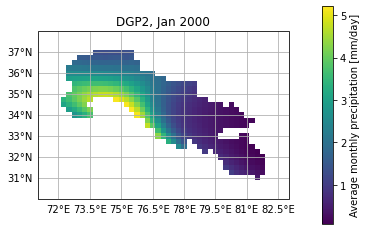

In [101]:
# plot
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.set_extent([71, 83, 30, 38])
g = da.pred.plot(cbar_kwargs={
            "label": "Average monthly precipitation [mm/day]",
            "extend": "neither", "pad": 0.10})
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("DGP3, Jan 2000")
plt.savefig("dgp3_latlon_jan200.png", format='png', dpi=300)
plt.show()